# Initial Imports

In [9]:
import argparse, sys, os, logging
import numpy as np
import pandas as pd
import powergrid_data
from hmmlearn import hmm
from datetime import datetime
from scipy import stats, special
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, normalize
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, HourLocator, AutoDateLocator, DateFormatter, AutoDateFormatter, date2num
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from analysis import analyzer
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

# Test and Train Files Directory

In [10]:
train = 'data/train/train.csv'
test = 'data/test/test_v1.csv'

# Extracting Data from csv files

In [11]:
power_grid = powergrid_data.datasets(train, test)
analyze = analyzer(power_grid)

# Seperate Features and Dates

> Note: Edit from here onwards

In [12]:
dates_columns = 'DateTime'
features_columns = ['Global_active_power']

analyze.time_series(dates_columns, features_columns)

# Assign the scope to the parser to extract data
> Scope can include years, months, days, hours, minutes and seconds to analyse data you want

In [13]:
## If you modify year, month and day, make sure the above dates_columns is either Date or DateTime

## Both test and train has data of year 2006, 2007 and 2008
Year = 2007

## Months takes a string of month full name e.g 'March'
Month = ['May']
Day = 5

## If you modify hour, minutes and seconds, make sure the above dates_columns is either DateTime or Time
## Hour uses 24 hr clock
Hour = None
Minutes = None
Seconds = None

train_dates, train_features, test_dates, test_features = analyze.parser(year = Year, month = Month, day = Day, hour = Hour, minutes = Minutes, seconds = Seconds)

# Training the model and extracting max likelihood hidden state sequence

In [14]:
# Make an HMM instance and execute fit

init_probability = np.array([0.6, 0.3, 0.1])

translation_probability = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.5, 0.2],
    [0.3, 0.3, 0.4]]
)

model = hmm.GaussianHMM(n_components=3, covariance_type="full", tol = 0.1, n_iter=500, init_params="st")
model.startprob_ = init_probability
model.transmat_ = translation_probability

model.fit(train_features)

train_state_seq = model.sample(test_features.size)[1]
test_state_seq = model.predict(test_features)

means = []
variance = []

for i in range(model.n_components):
    means.append(model.means_[i].flatten()[0])
    variance.append(model.covars_[i].flatten()[0])

standard_deviation = np.sqrt(variance)

# Filtering Anomaly Data and applying Thresholding

In [15]:
anom = []
notanom = []
meanStates = []

test_observation = test_features.values

# thresholds 0.5, 1, 1.25 ,1.5, 1.75 and 2
threshold = 0.5
for i in range(test_observation.size):
    state = test_state_seq[i]
    if (np.abs(means[state] - test_observation[i]) <= threshold):
        notanom.append(True)
    else:
        notanom.append(False)
    meanStates.append(means[state])

test_features_anomaly = np.copy(test_observation)
test_features_anomaly[notanom] = None

# Display Graph

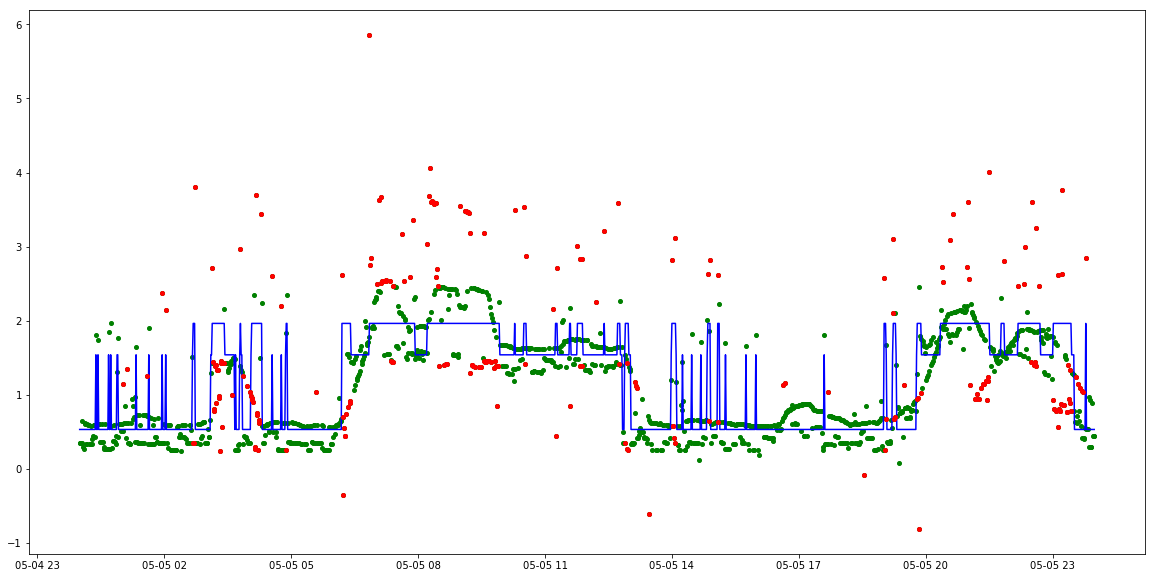

In [8]:
plt.figure(figsize=(20,10))
plt.plot(test_dates, test_observation, 'go', markersize=4)
plt.plot(test_dates, meanStates, 'b', markersize=4)
plt.plot(test_dates, test_features_anomaly, 'ro', markersize=4)